In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lastlab2022compx310/train.csv
/kaggle/input/lastlab2022compx310/test.csv


Loading the Data

In [2]:
train_csv = pd.read_csv("/kaggle/input/lastlab2022compx310/train.csv", na_values=-9999)
test_csv = pd.read_csv("/kaggle/input/lastlab2022compx310/test.csv", na_values=-9999)
#train_csv.info()
#test_csv.info()
print(train_csv.head())
print(test_csv.head())

   id   a0    a1   a2   a3   a4   a5   a6   a7   a8  ...  a56  a57  a58  a59  \
0   0  5.0   1.0  1.0  0.0  0.0  7.0  5.0  2.0  2.0  ...  1.0  0.0  NaN  1.0   
1   1  2.0   1.0  2.0  0.0  0.0  1.0  2.0  2.0  2.0  ...  4.0  0.0  1.0  1.0   
2   2  7.0  11.0  1.0  0.0  0.0  0.0  0.0  1.0  NaN  ...  0.0  0.0  0.0  2.0   
3   3  7.0   1.0  1.0  3.0  0.0  0.0  0.0  2.0  2.0  ...  0.0  0.0  0.0  2.0   
4   4  3.0  11.0  1.0  0.0  0.0  2.0  3.0  2.0  2.0  ...  5.0  0.0  1.0  1.0   

   a60  a61   a62  a63  a64  target  
0  1.0  0.0  10.0  1.0  0.0      c1  
1  1.0  0.0   8.0  1.0  0.0      c1  
2  2.0  0.0   4.0  7.0  0.0      c0  
3  2.0  0.0  10.0  6.0  0.0      c0  
4  1.0  0.0  11.0  1.0  0.0      c1  

[5 rows x 67 columns]
        id   a0    a1   a2   a3   a4   a5   a6   a7   a8  ...  a55  a56  a57  \
0  1000000  4.0   1.0  7.0  0.0  0.0  1.0  0.0  2.0  2.0  ...  3.0  0.0  0.0   
1  1000001  6.0  11.0  1.0  0.0  0.0  6.0  0.0  2.0  2.0  ...  3.0  0.0  0.0   
2  1000002  4.0   9.0  1.0  

Data Preprocessing

In [6]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

my_ID = 1506427

scaler = StandardScaler()
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent') #'median' for everything except xgboost

# drop id and target
X_train = train_csv.drop(['id','target'], axis = 1)

# drop target for y_train
y_train_val = np.unique(train_csv['target'], return_inverse = True)[1].tolist()

# drop id or test data
test_data = test_csv.drop(['id'], axis = 1)

# impute x_train and test
imputer.fit(X_train)
X_train = imputer.transform(X_train)
test_data = imputer.transform(test_data)

# scale data
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
test_data_scaled = scaler.transform(test_data)

# split into train and valdation
X_train, X_val, y_train, y_val = train_test_split(X_scaled,y_train_val,test_size=0.2, stratify=y_train_val, random_state=my_ID)

# Check
print(X_train.shape, X_val.shape)

(655542, 65) (163886, 65)


Logistic Regression - after testing a few combinations I found 'l2 saga 1' to give the highest accuracy

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

solver_penalty = [['saga', 'l2'], ['saga', 'l1']]
# c_list = [0.2, 0.4, 0.6, 0.8, 1]
c_list = [0.5,1]

def logistic_regression(P, S, c, X_train, y_train, X_val, y_val):
    lr = LogisticRegression(penalty = P, solver = S, C=c, max_iter=1000)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    print("Accuracy " + str(accuracy) + " " + str(P) + " " + str(S) + " " + str(c))

'''    
for s, p in solver_penalty:
    for c in c_list:
        logistic_regression(p, s, c, X_train, y_train, X_val, y_val)
'''
        
logistic_regression('l2', 'saga', 1, X_train, y_train, X_val, y_val)

Accuracy 0.8137241741210354 l2 saga 1


Decision Trees - after testing a few combinations I found 'entropy best 420' to give the highest accuracy

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier 

criterion_list = ['gini','entropy'] # omit log_loss due to key error
splitter_list = ['best','random']
min_sample = [400, 410, 420, 425] # 2 is default, try 3 4 5, 4 6 8 10 12 14 16 18 20

def decision_tree(c, s, m, X_train, y_train, X_val, y_val):
    clf = DecisionTreeClassifier(random_state=my_ID, criterion = c, splitter = s, min_samples_split = m)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    print("Accuracy " + str(accuracy) + " " + str(c) + " " + str(s) + " " + str(m))

'''
for c in criterion_list:
    for s in splitter_list:
        for m in min_sample:
            decision_tree(c, s, m, X_train, y_train, X_val, y_val)
'''
            
decision_tree('entropy', 'best', 420, X_train, y_train, X_val, y_val)

Accuracy 0.825506754695337 entropy best 420


Ensemble Classifier - XGBoost, this was one of the best results that I get with the train and validation split in the data

In [4]:
# randomforrest vs xgboost vs adaboost, xgboost is parallel so use this?
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=my_ID, num_class=5, tree_method = 'hist',n_estimators=147) #'gpu_hist')
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print("Accuracy " + str(accuracy))

Accuracy 0.8391564868262085


In [5]:
# built in cross validation, want high boost but not too high
param = {'max_depth':2, 'eta':1, 'objective':'multi:softmax', 'num_class':5}
dtrain = xgb.DMatrix(X_scaled, y_train_val)
res = xgb.cv(param, dtrain, num_boost_round=150, nfold=5, metrics={'merror'}, seed=my_ID)
print(res)                        

# look at 1st and 3rd columns
# train acc go down but test going up - is the point where we choose number of boost rounds
# smallest in test error mean, same index in train is accuracy

df = pd.DataFrame(res)
index = df['test-merror-mean'].idxmin()
row = df.iloc[[index]]
print("Accuracy " + str(1 - row.iloc[:,0]))

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0             0.245280          0.000222          0.245297         0.000643
1             0.211005          0.000399          0.211000         0.000275
2             0.209397          0.000216          0.209436         0.000704
3             0.203084          0.000717          0.203172         0.000830
4             0.195060          0.000726          0.195305         0.000678
..                 ...               ...               ...              ...
145           0.161251          0.000110          0.162671         0.000226
146           0.161237          0.000099          0.162662         0.000227
147           0.161222          0.000100          0.162710         0.000231
148           0.161187          0.000100          0.162685         0.000245
149           0.161164          0.000120          0.162624         0.000190

[150 rows x 4 columns]
Accuracy 149    0.838836
Name: train-merror-mean, dtype: float64

Neural Network - I found fewer but wider layers gave better results

2022-10-30 03:05:01.492014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-30 03:05:02.346203: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
11/11 [==============================] - 21s 2s/step - loss: 1.0523 - accuracy: 0.5630 - val_loss: 0.7169 - val_accuracy: 0.6957
Epoch 2/100
11/11 [==============================] - 19s 2s/step - loss: 0.6633 - accuracy: 0.7309 - val_loss: 0.5978 - val_accuracy: 0.7568
Epoch 3/100
11/11 [==============================] - 20s 2s/step - loss: 0.5676 - accuracy: 0.7704 - val_loss: 0.5342 - val_accuracy: 0.7860
Epoch 4/100
11/11 [==============================] - 20s 2s/step - loss: 0.5178 - accuracy: 0.7909 - val_loss: 0.4989 - val_accuracy: 0.7948
Epoch 5/100
11/11 [==============================] - 19s 2s/step - loss: 0.4888 - accuracy: 0.7991 - val_loss: 0.4762 - val_accuracy: 0.8010
Epoch 6/100
11/11 [==============================] - 20s 2s/step - loss: 0.4702 - accuracy: 0.8041 - val_loss: 0.4628 - val_accuracy: 0.8072
Epoch 7/100
11/11 [==============================] - 19s 2s/step - loss: 0.4580 - accuracy: 0.8094 - val_loss: 0.4534 - val_accuracy: 0.8100
Epoch 8/100
1

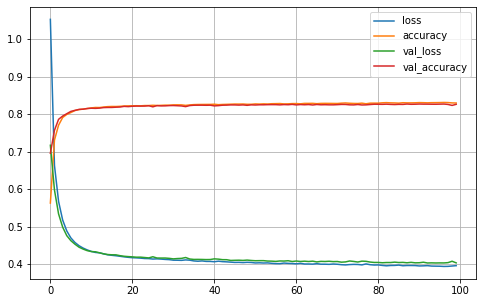

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf
from tensorflow import keras

model = Sequential()
model.add(keras.layers.Dense(700, activation="relu")) # also potentially add dropout layers between dense layers
model.add(keras.layers.Dense(700, activation="relu")) 
model.add(keras.layers.Dense(5, activation="softmax")) # try widening layers and potentially making it deeper? more epochs?

# learning rate
opt=keras.optimizers.Adam(learning_rate=0.0003)

# compile
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit
history = model.fit(X_train, np.array(y_train), validation_data=(X_val,np.array(y_val)), batch_size=65526, epochs=100) # experiment with epochs value

print("Accuracy " + str(history.history['val_accuracy'][-1]))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

The modified XGBoost code that gave me the best accuracy in the Kaggle competition, don't worry about the prediction accuracy because this is incorrect due to the validation data also being in the training data set. This was due to the idea of: train more data -> get better test score 

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=my_ID, num_class=5, tree_method = 'hist',n_estimators=478, max_depth=4) #'gpu_hist')
xgb_model.fit(X_scaled, y_train_val)
predictions = xgb_model.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print("Accuracy " + str(accuracy))

Accuracy 0.8479430823865369


Code to predict on the test data and output a csv for the competition

In [11]:
# submission
out = xgb_model.predict(test_data_scaled) # xgbboost
# out = model.predict(test_data_scaled) #neural network

import os
os.chdir(r'/kaggle/working')

data={ 'id': test_csv.id.values, 'target':out}
out = pd.DataFrame(data=data)
out = out.replace(0,'c0')
out = out.replace(1,'c1')
out = out.replace(2,'c2')
out = out.replace(3,'c3')
out = out.replace(4,'c4')

out.to_csv(r'output.csv', index=False)

from IPython.display import FileLink
FileLink(r'output.csv')

#pca transform

/kaggle/working/output.csv